# CNN Model (multiple) for shifted MIT data
As we concluded before, for MIT data, we apply the following preprocessing:   
resampling: Oversampling \
rescaling: MinMax Scaler

If you don't have the original files: run the notebook 'preprocessing_mit_multipleclass_shift_minmax_oversampling.ipynb'    
Input file: (The preprocessed data)   
mitbih_train_multiclass_shift_minmax_oversampling.csv
mitbih_test_multiclass_shift_minmax_oversampling.csv

Output: CNN model trained  
model_mit_multiple_shift_cnn.h5


In [10]:
import sys
import os

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q
    !pip install matplotlib -q
    !pip install seaborn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive.
    data_path = '/content/drive/MyDrive/data/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: c:\Users\igurs\Documents\GitHub\heartbeat-analysis-ai\notebooks


## Read data


In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

RawFiles = dict({
    'train': data_path + 'mitbih_multipleclass_train_shift_minmax_oversampling.csv',
    'test': data_path + 'mitbih_multipleclass_test_shift_minmax_oversampling.csv'
})


OutputFiles = dict({
    'model': model_output_path +  'model_mit_multiple_shift_cnn' 
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



In [12]:
# Convert DataFrames to NumPy arrays
X_train = X_train.values
X_test = X_test.values

# Reshape data for (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Check the shape
print("X_train shape:", X_train.shape)  # Should be (num_samples, timesteps, 1)
print("X_test shape:", X_test.shape)    # Should be (num_samples, timesteps, 1)


X_train shape: (289884, 187, 1)
X_test shape: (20284, 187, 1)


In [13]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# 1D CNN with MinMax Scaler and Oversampling

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, f1_score

# Seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Define the 1D CNN model for multi-class classification
model = Sequential()
model.add(Conv1D(187, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  

# Compile model
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor="val_loss",
    min_delta=0.01,
    patience=3,
    factor=0.1,
    cooldown=4,
    verbose=1
)

# Train Model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_learning_rate],
    verbose=1
)


c:\Users\igurs\anaconda3\envs\project_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 185, 187)       │           748 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 185, 187)       │           748 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 92, 187)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 92, 187)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 90, 64)         │        35,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 90, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       184,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,364 (868.61 KB)

 Trainable params: 221,862 (866.65 KB)

 Non-trainable params: 502 (1.96 KB)

Epoch 1/100
18118/18118 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - AUC: 0.9242 - accuracy: 0.7507 - loss: 0.6524 - val_AUC: 0.9892 - val_accuracy: 0.9212 - val_loss: 0.2498 - learning_rate: 0.0010
Epoch 2/100
18118/18118 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - AUC: 0.9827 - accuracy: 0.8848 - loss: 0.3106 - val_AUC: 0.9906 - val_accuracy: 0.9213 - val_loss: 0.2361 - learning_rate: 0.0010
Epoch 3/100
18118/18118 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - AUC: 0.9876 - accuracy: 0.9049 - loss: 0.2572 - val_AUC: 0.9911 - val_accuracy: 0.9197 - val_loss: 0.2236 - learning_rate: 0.0010
Epoch 4/100
18118/18118 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - AUC: 0.9896 - accuracy: 0.9152 - loss: 0.2322 - val_AUC: 0.9923 - val_accuracy: 0.9272 - val_loss: 0.2160 - learning_rate: 0.0010
Epoch 5/100
18118/18118 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - AUC: 0.9911 - accuracy: 0.9231 - loss: 0.2132 - val_AUC: 0.9946 - val_accuracy: 0.9495 - val_loss: 0.1670 - learning_rate: 0.0010
Epoch 6/100
18118/18118 ━━━━━━━━━━━━━━━━━━━━ 67s 4

In [15]:
# Train Scores
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Robust handling of accuracy keys
train_accuracy = history.history.get('sparse_categorical_accuracy', history.history.get('accuracy'))
val_accuracy = history.history.get('val_sparse_categorical_accuracy', history.history.get('val_accuracy'))

if train_accuracy is not None and val_accuracy is not None:
    print(f"Final Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
          f"Accuracy: {train_accuracy[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")
else:
    print(f"Final Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}")
    print("Accuracy metrics are not available in the training history.")

# Prediction
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class predictions
print(f"Predicted Classes: {y_pred_classes[:10]}")

Final Loss: 0.1508, Val Loss: 0.1471, Accuracy: 0.9467, Val Accuracy: 0.9488
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicted Classes: [0 0 0 0 0 0 0 0 0 0]


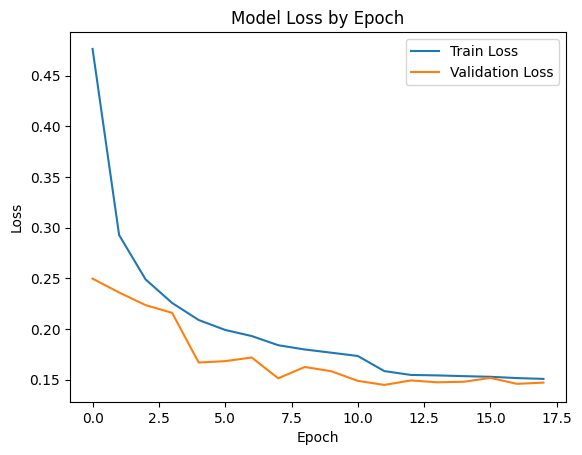

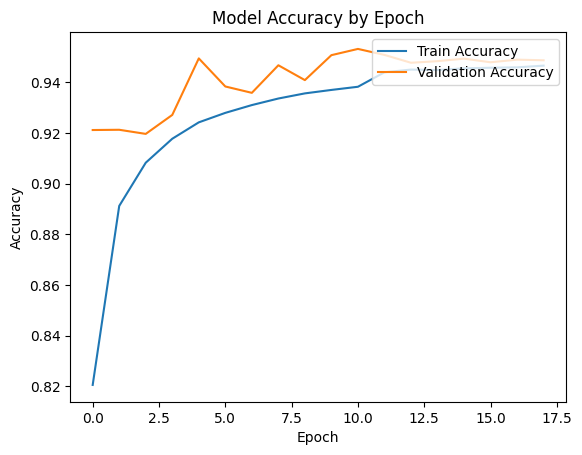

634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [16]:
import matplotlib.pyplot as plt

# Plotting the Loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plotting the Accuracy
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Making predictions
y_pred = model.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)


In [17]:
# Convert probabilities to class predictions
y_pred_class = np.argmax(y_pred, axis=1) # argmax returns the index of the max value

# Convert one-hot encoded `y_test` to class labels
y_test_class = np.argmax(y_test, axis=1)

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred_class))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test_class, y_pred_class))

# F1 Score
print(f"F1 Score: {f1_score(y_test_class, y_pred_class, average='weighted'):.4f}") 

Confusion Matrix:
 [[17189   305   243   381]
 [   50   495     8     3]
 [   29     5  1372    42]
 [    2     2     9   149]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     18118
           1       0.61      0.89      0.73       556
           2       0.84      0.95      0.89      1448
           3       0.26      0.92      0.40       162

    accuracy                           0.95     20284
   macro avg       0.68      0.93      0.75     20284
weighted avg       0.97      0.95      0.95     20284

F1 Score: 0.9545


# Save model

In [19]:
# Save the model in HDF5 format
model_path = OutputFiles.get('model') + '.h5'  # Append .h5 extension
model.save(model_path)
print(f"Model saved to {model_path}")


Model saved to ../models/model_mit_multiple_shift_cnn.h5


In [20]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-12-12 15:50:04.679042
